# Heart Disease Classification

## Introduction

Of all the applications of machine-learning, diagnosing any serious disease using a black box is always going to be a hard sell. If the output from a model is the particular course of treatment (potentially with side-effects), or surgery, or the *absence* of treatment, people are going to want to know **why**.

The following models will be explored:
1. Logistic regression - Manual and sklearn
2. KNN
3. SVM
4. Naïve Bayes
5. Decision Tree
6. Random Forests 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

## Reading Data

In [3]:
df = pd.read_csv("data/heart.csv")

<IPython.core.display.Javascript object>

In [4]:
df.head(4)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1


<IPython.core.display.Javascript object>

It's a clean, easy to understand set of data. However, the meaning of some of the column headers are not obvious. Here's what they mean,

- **age**: The person's age in years
- **sex**: The person's sex (1 = male, 0 = female)
- **cp:** The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)
- **trestbps:** The person's resting blood pressure (mm Hg on admission to the hospital)
- **chol:** The person's cholesterol measurement in mg/dl
- **fbs:** The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false) 
- **restecg:** Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
- **thalach:** The person's maximum heart rate achieved
- **exang:** Exercise induced angina (1 = yes; 0 = no)
- **oldpeak:** ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot. See more [here](https://litfl.com/st-segment-ecg-library/))
- **slope:** the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
- **ca:** The number of major vessels (0-3)
- **thal:** A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)
- **target:** Heart disease (0 = no, 1 = yes)

**Diagnosis**: The diagnosis of heart disease is done on a combination of clinical signs and test results. The types of tests run will be chosen on the basis of what the physician thinks is going on [1](https://www.mayoclinic.org/diseases-conditions/heart-disease/diagnosis-treatment/drc-20353124), ranging from electrocardiograms and cardiac computerized tomography (CT) scans, to blood tests and exercise stress tests [2](https://www.heartfoundation.org.au/your-heart/living-with-heart-disease/medical-tests).

Looking at information of heart disease risk factors led me to the following: **high cholesterol, high blood pressure, diabetes, weight, family history and smoking** [3](https://www.bhf.org.uk/informationsupport/risk-factors). According to another source [4](https://www.heart.org/en/health-topics/heart-attack/understand-your-risks-to-prevent-a-heart-attack), the major factors that can't be changed are: **increasing age, male gender and heredity**. Note that **thalassemia**, one of the variables in this dataset, is heredity. Major factors that can be modified are: **Smoking, high cholesterol, high blood pressure, physical inactivity, and being overweight and having diabetes**. Other factors include **stress, alcohol and poor diet/nutrition**.

I can see no reference to the 'number of major vessels', but given that the definition of heart disease is **"...what happens when your heart's blood supply is blocked or interrupted by a build-up of fatty substances in the coronary arteries"**, it seems logical the *more* major vessels is a good thing, and therefore will reduce the probability of heart disease.

Given the above, I would hypothesis that, if the model has some predictive ability, we'll see these factors standing out as the most important.

## Data Exploration

In [5]:
df.target.value_counts()

1    165
0    138
Name: target, dtype: int64

<IPython.core.display.Javascript object>

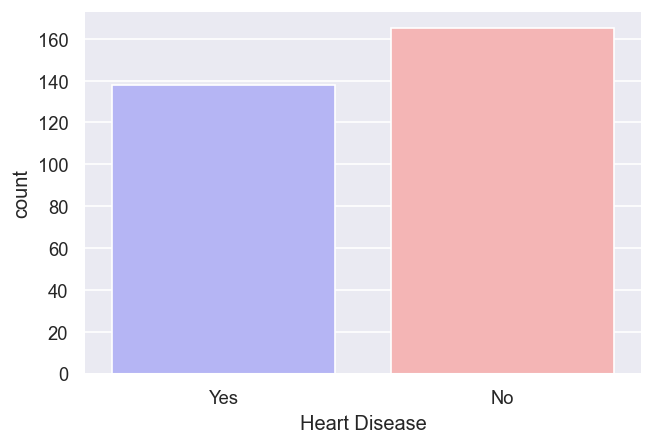

<IPython.core.display.Javascript object>

In [6]:
sns.set(rc={"figure.figsize": (6, 4), "figure.dpi": 120})
target_countplot = sns.countplot(x="target", data=df, palette="bwr")
target_countplot.set(xticklabels=["Yes", "No"])
plt.xlabel("Heart Disease")
plt.show()

In [7]:
countNoDisease = len(df[df.target == 0])
countHaveDisease = len(df[df.target == 1])
print(
    "Percentage of Patients Haven't Heart Disease: {:.2f}%".format(
        (countNoDisease / (len(df.target)) * 100)
    )
)
print(
    "Percentage of Patients Have Heart Disease: {:.2f}%".format(
        (countHaveDisease / (len(df.target)) * 100)
    )
)

Percentage of Patients Haven't Heart Disease: 45.54%
Percentage of Patients Have Heart Disease: 54.46%


<IPython.core.display.Javascript object>

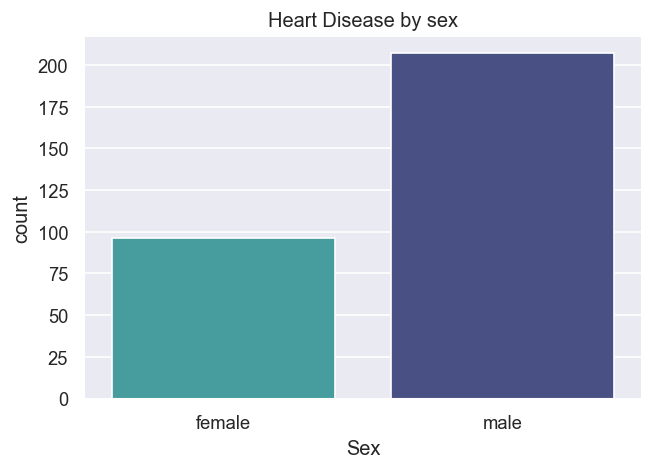

<IPython.core.display.Javascript object>

In [8]:
sns.set(rc={"figure.figsize": (6, 4), "figure.dpi": 120})
sex_countplot = sns.countplot(x="sex", data=df, palette="mako_r")
sex_countplot.set(xticklabels=["female", "male"])
plt.xlabel("Sex")
plt.title("Heart Disease by sex")
plt.show()

In [9]:
countFemale = len(df[df.sex == 0])
countMale = len(df[df.sex == 1])
print(
    "Percentage of Female Patients: {:.2f}%".format((countFemale / (len(df.sex)) * 100))
)
print("Percentage of Male Patients: {:.2f}%".format((countMale / (len(df.sex)) * 100)))

Percentage of Female Patients: 31.68%
Percentage of Male Patients: 68.32%


<IPython.core.display.Javascript object>

In [10]:
df.groupby("target").mean()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
target,,,,,,,,,,,,,
0,56.601449,0.826087,0.478261,134.398551,251.086957,0.159420,0.449275,139.101449,0.550725,1.585507,1.166667,1.166667,2.543478
1,52.496970,0.563636,1.375758,129.303030,242.230303,0.139394,0.593939,158.466667,0.139394,0.583030,1.593939,0.363636,2.121212


<IPython.core.display.Javascript object>

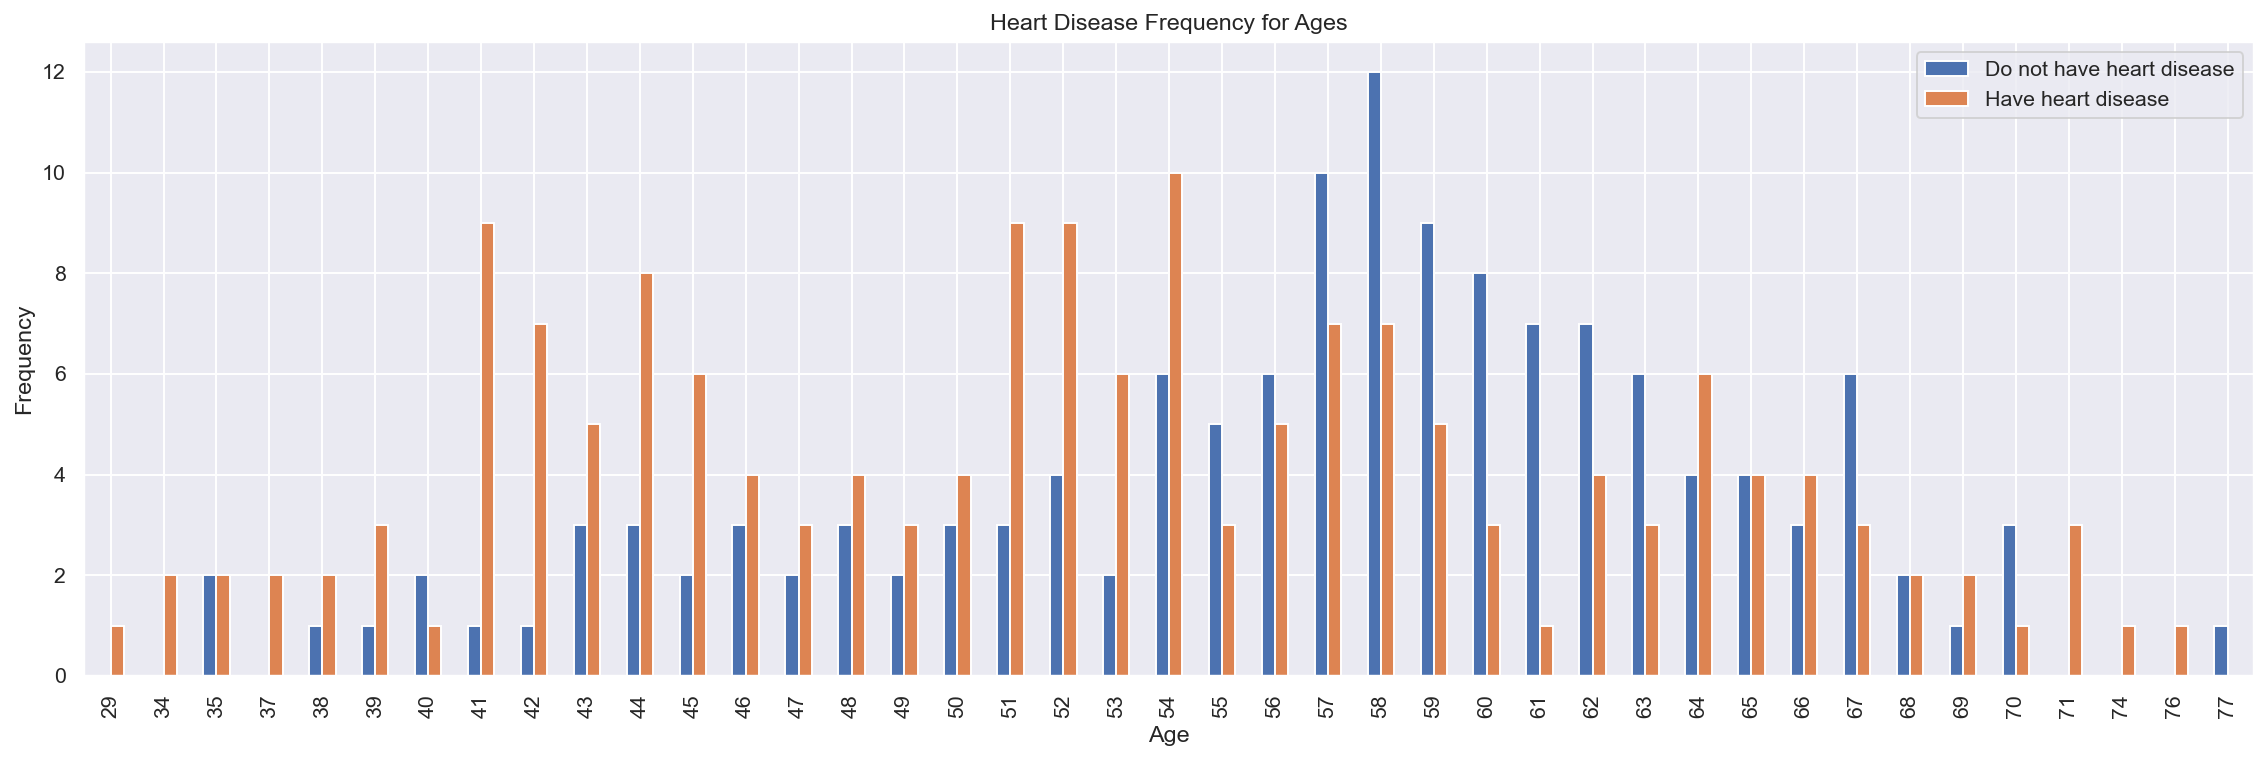

<IPython.core.display.Javascript object>

In [11]:
plt.figure(dpi=140)
pd.crosstab(df.age, df.target).plot(kind="bar", figsize=(20, 6), ax=plt.gca())
plt.title("Heart Disease Frequency for Ages")
plt.legend(["Do not have heart disease", "Have heart disease"])
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

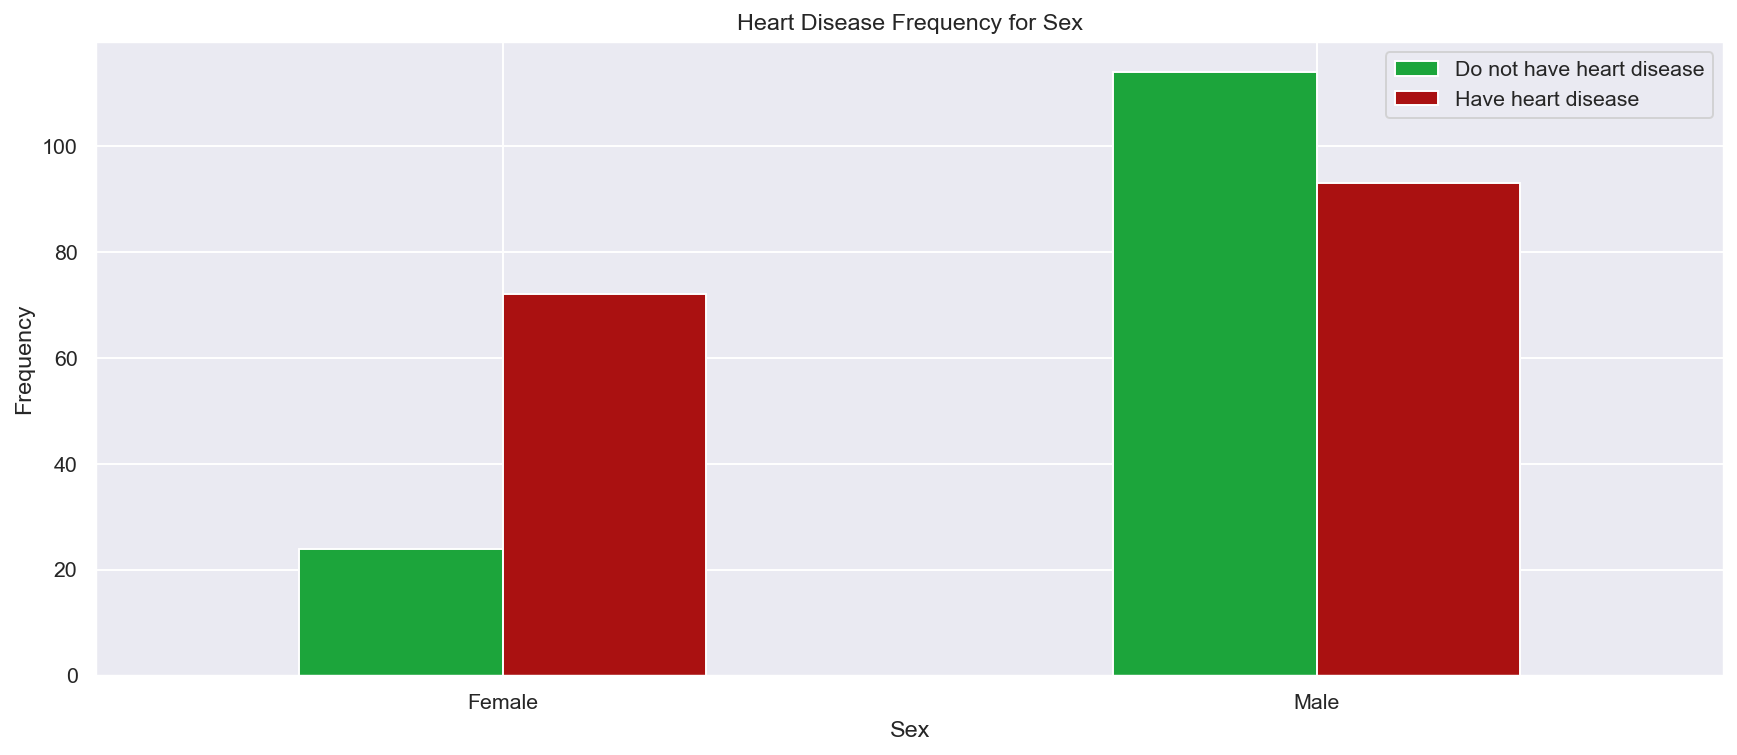

<IPython.core.display.Javascript object>

In [12]:
plt.figure(dpi=140)
pd.crosstab(df.sex, df.target).plot(
    kind="bar", figsize=(15, 6), color=["#1CA53B", "#AA1111"], ax=plt.gca()
)
plt.title("Heart Disease Frequency for Sex")
plt.xlabel("Sex")
plt.xticks(rotation=0)
plt.gca().set_xticklabels(labels=["Female", "Male"])
plt.legend(["Do not have heart disease", "Have heart disease"])
plt.ylabel("Frequency")
plt.show()

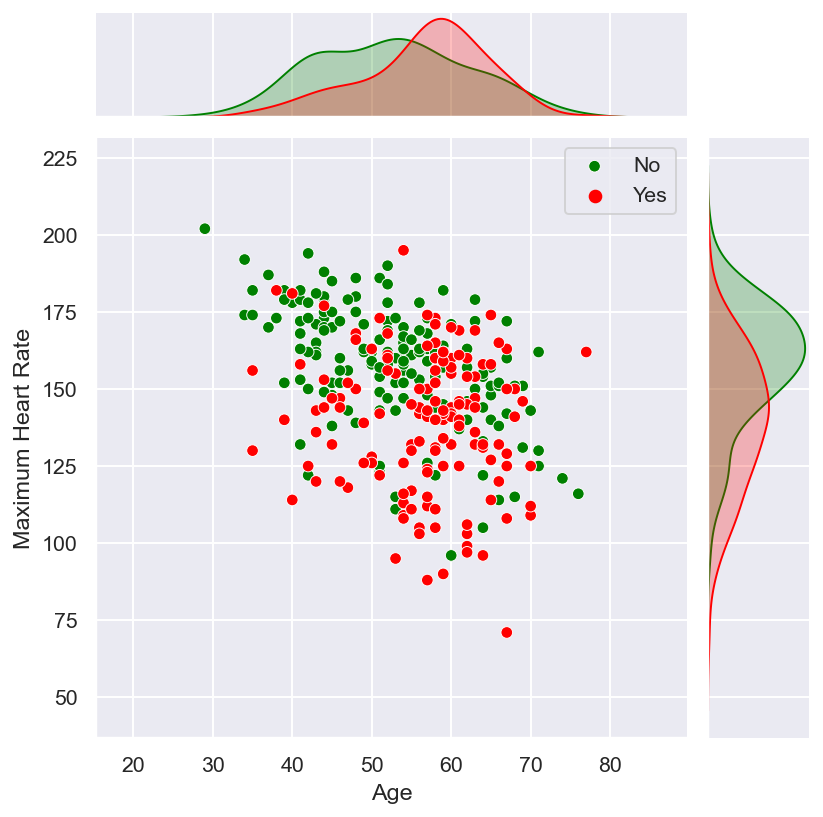

<IPython.core.display.Javascript object>

In [13]:
sns.set(rc={"figure.figsize": (5, 3), "figure.dpi": 140})
g = sns.jointplot(x="age", y="thalach", hue="target", data=df, palette=["red", "green"])
g.ax_joint.legend(labels=["No", "Yes"])
g.ax_joint.set_xlabel("Age")
g.ax_joint.set_ylabel("Maximum Heart Rate")
plt.show()

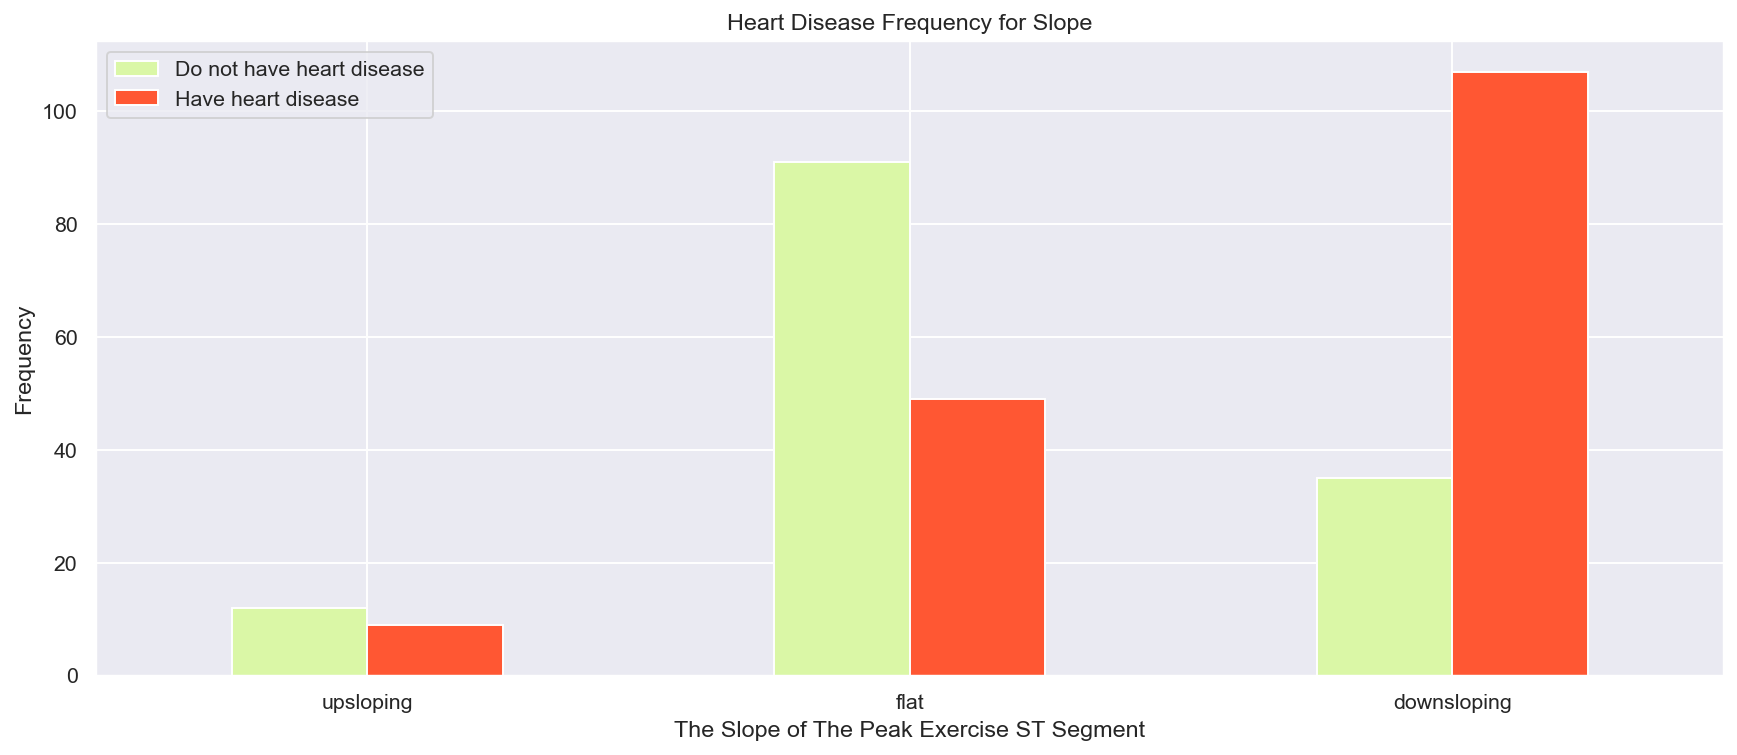

<IPython.core.display.Javascript object>

In [14]:
plt.figure(dpi=140)
pd.crosstab(df.slope, df.target).plot(
    kind="bar", figsize=(15, 6), color=["#DAF7A6", "#FF5733"], ax=plt.gca()
)
plt.legend(["Do not have heart disease", "Have heart disease"])
plt.title("Heart Disease Frequency for Slope")
plt.xlabel("The Slope of The Peak Exercise ST Segment")
plt.xticks(rotation=0)
plt.gca().set_xticklabels(labels=["upsloping", "flat", "downsloping"])
plt.ylabel("Frequency")
plt.show()

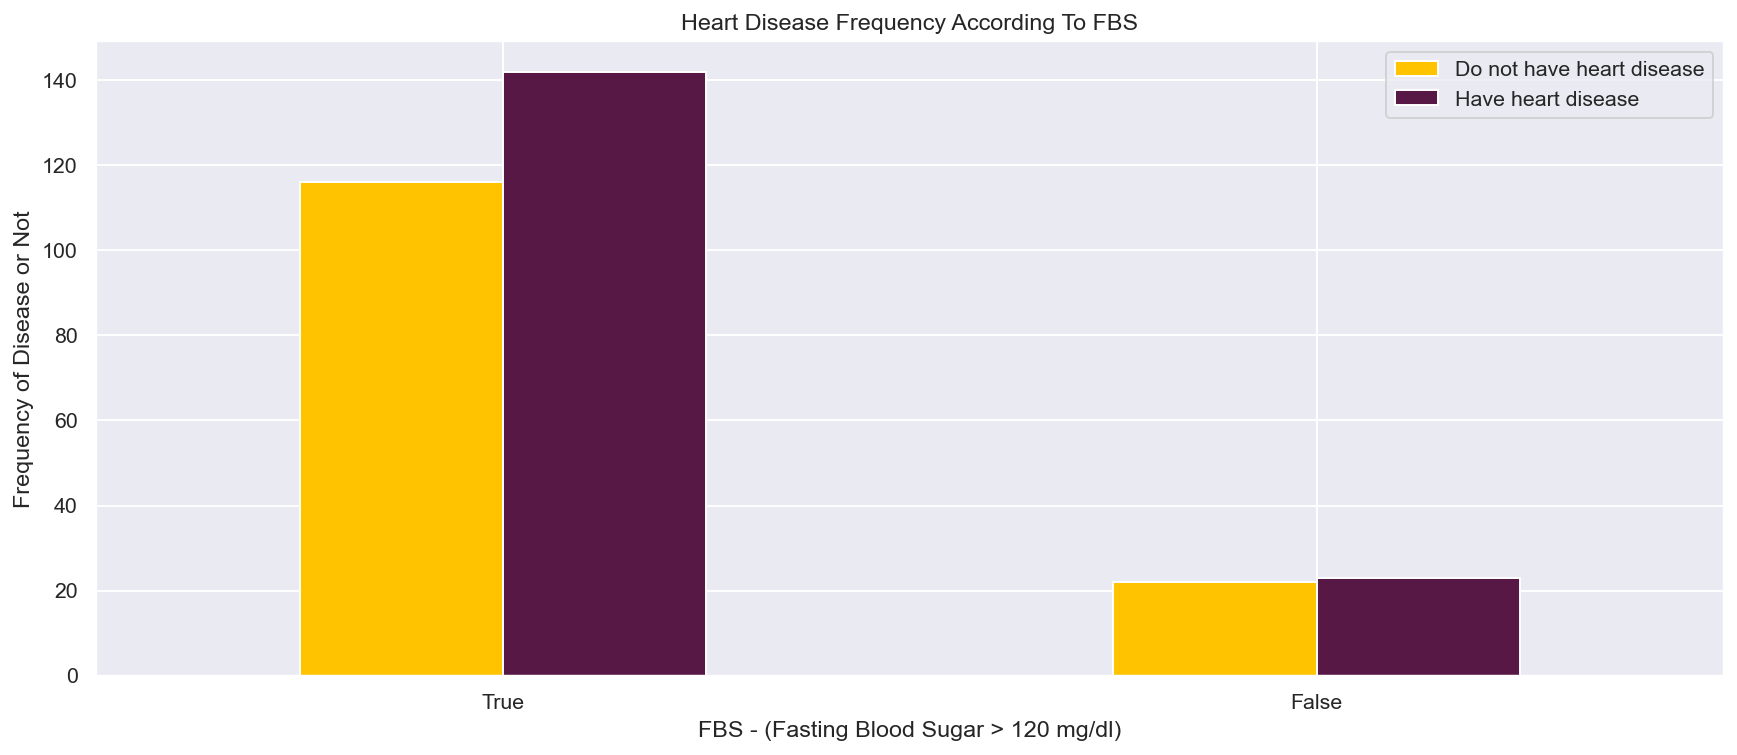

<IPython.core.display.Javascript object>

In [15]:
plt.figure(dpi=140)
pd.crosstab(df.fbs, df.target).plot(
    kind="bar", figsize=(15, 6), color=["#FFC300", "#581845"], ax=plt.gca()
)
plt.title("Heart Disease Frequency According To FBS")
plt.legend(["Do not have heart disease", "Have heart disease"])
plt.xlabel("FBS - (Fasting Blood Sugar > 120 mg/dl)")
plt.gca().set_xticklabels(labels=["True", "False"])
plt.xticks(rotation=0)
plt.ylabel("Frequency of Disease or Not")
plt.show()

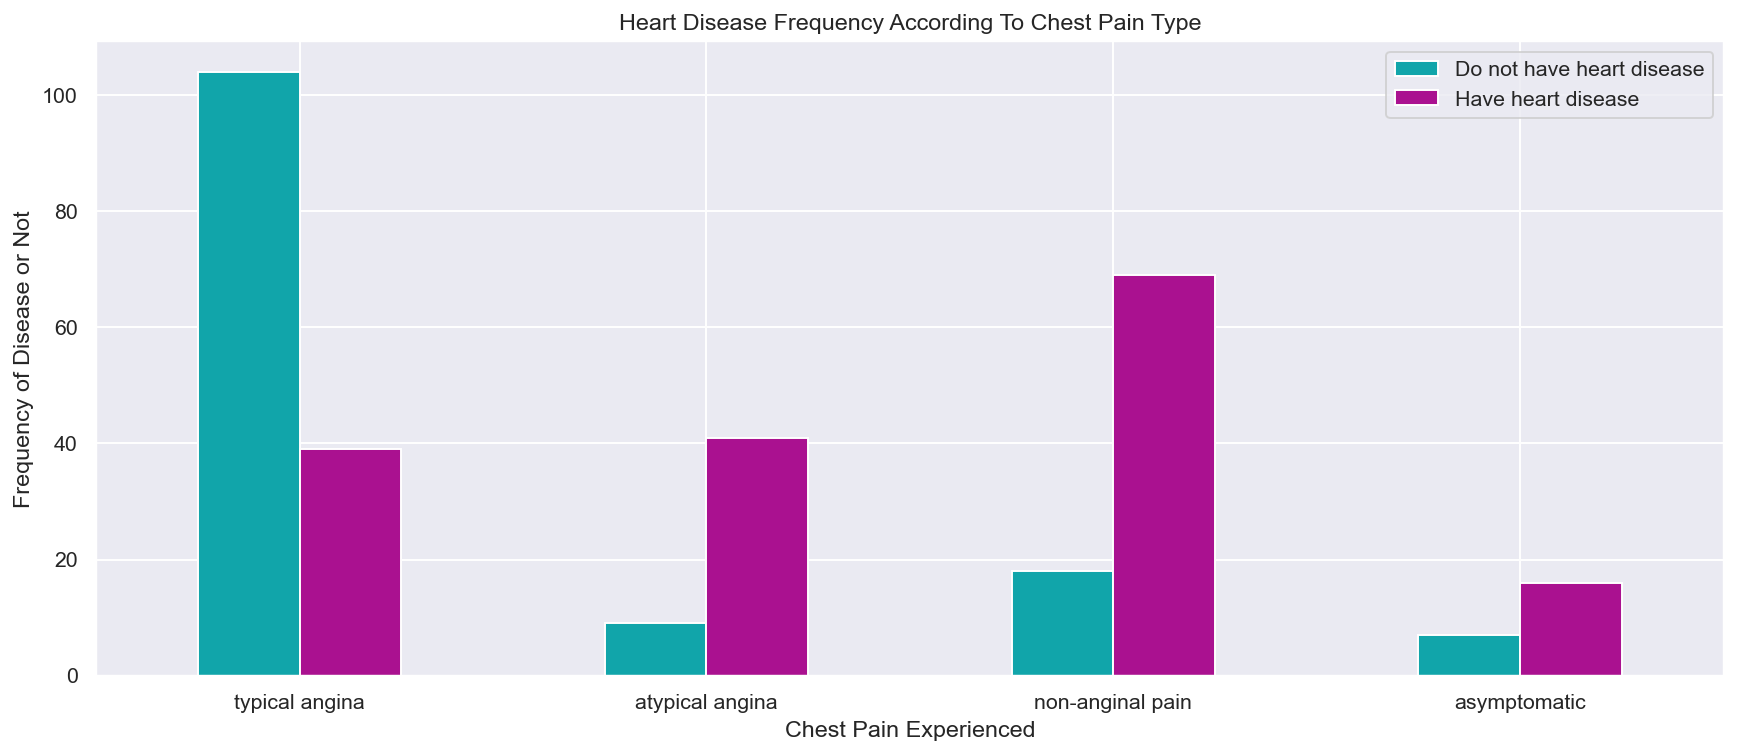

<IPython.core.display.Javascript object>

In [16]:
plt.figure(dpi=140)
pd.crosstab(df.cp, df.target).plot(
    kind="bar", figsize=(15, 6), color=["#11A5AA", "#AA1190"], ax=plt.gca()
)
plt.title("Heart Disease Frequency According To Chest Pain Type")
plt.legend(["Do not have heart disease", "Have heart disease"])
plt.xlabel("Chest Pain Experienced")
plt.gca().set_xticklabels(
    labels=["typical angina", "atypical angina", "non-anginal pain", "asymptomatic"]
)
plt.xticks(rotation=0)
plt.ylabel("Frequency of Disease or Not")
plt.show()

### Creating Dummy Variables

![](http://)Since 'cp', 'thal' and 'slope' are categorical variables we'll turn them into dummy variables.

In [17]:
a = pd.get_dummies(df["cp"], prefix="cp")
b = pd.get_dummies(df["thal"], prefix="thal")
c = pd.get_dummies(df["slope"], prefix="slope")

<IPython.core.display.Javascript object>

In [18]:
frames = [df, a, b, c]
df = pd.concat(frames, axis=1)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,63,1,3,145,233,1,0,150,0,2.3,...,0,0,1,0,1,0,0,1,0,0
1,37,1,2,130,250,0,1,187,0,3.5,...,0,1,0,0,0,1,0,1,0,0
2,41,0,1,130,204,0,0,172,0,1.4,...,1,0,0,0,0,1,0,0,0,1
3,56,1,1,120,236,0,1,178,0,0.8,...,1,0,0,0,0,1,0,0,0,1
4,57,0,0,120,354,0,1,163,1,0.6,...,0,0,0,0,0,1,0,0,0,1


<IPython.core.display.Javascript object>

In [19]:
df = df.drop(columns=["cp", "thal", "slope"])
df.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,63,1,145,233,1,0,150,0,2.3,0,...,0,0,1,0,1,0,0,1,0,0
1,37,1,130,250,0,1,187,0,3.5,0,...,0,1,0,0,0,1,0,1,0,0
2,41,0,130,204,0,0,172,0,1.4,0,...,1,0,0,0,0,1,0,0,0,1
3,56,1,120,236,0,1,178,0,0.8,0,...,1,0,0,0,0,1,0,0,0,1
4,57,0,120,354,0,1,163,1,0.6,0,...,0,0,0,0,0,1,0,0,0,1


<IPython.core.display.Javascript object>

## Logistic Regression


In [20]:
y = df.target.values
x_data = df.drop(["target"], axis=1)

<IPython.core.display.Javascript object>

### Normalize Data
<br>
<br>
<img src="https://beyondbacktesting.files.wordpress.com/2017/07/normalization.png?w=863" width="400px"/>

In [21]:
# Normalize
x = (x_data - np.min(x_data)) / (np.max(x_data) - np.min(x_data)).values

<IPython.core.display.Javascript object>

We will split our data. 80% of our data will be train data and 20% of it will be test data.

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

<IPython.core.display.Javascript object>

In [23]:
# transpose matrices
x_train = x_train.T
y_train = y_train.T
x_test = x_test.T
y_test = y_test.T

<IPython.core.display.Javascript object>

Let's say weight = 0.01 and bias = 0.0

In [24]:
def initialize(dimension):
    weight = np.full((dimension, 1), 0.01)
    bias = 0.0
    return weight, bias

<IPython.core.display.Javascript object>

### Sigmoid Function
<br>
<img src="https://qph.fs.quoracdn.net/main-qimg-05edc1873d0103e36064862a45566dba" width="500px"/>

In [25]:
def sigmoid(z):
    y_hat = 1 / (1 + np.exp(-z))
    return y_hat

<IPython.core.display.Javascript object>

### Forward and Backward Propagation
<br>
<img src="https://image.slidesharecdn.com/gradientdescentbackpropandautomaticdifferentiation-160829164205/95/gradient-descent-back-propagation-and-auto-differentiation-advanced-spark-and-tensorflow-meetup-08042016-62-638.jpg?cb=1472489358" width="500px"/>

### Cost Function
<br>
<img src="https://i.stack.imgur.com/XbU4S.png" width="500px"/>

### Gradient Descent
<br>
<img src="https://i.stack.imgur.com/pYVzl.png" width="500px"/>

In [26]:
def forwardBackward(weight, bias, x_train, y_train):
    # Forward
    y_hat = sigmoid(np.dot(weight.T, x_train) + bias)
    loss = -(y_train * np.log(y_hat) + (1 - y_train) * np.log(1 - y_hat))
    cost = np.sum(loss) / x_train.shape[1]

    # Backward
    derivative_weight = np.dot(x_train, ((y_hat - y_train).T)) / x_train.shape[1]
    derivative_bias = np.sum(y_hat - y_train) / x_train.shape[1]
    gradients = {
        "Derivative Weight": derivative_weight,
        "Derivative Bias": derivative_bias,
    }

    return cost, gradients

<IPython.core.display.Javascript object>

In [27]:
def update(weight, bias, x_train, y_train, learningRate, iteration):
    costList = []
    index = []

    # for each iteration, update weight and bias values
    for i in range(iteration):
        cost, gradients = forwardBackward(weight, bias, x_train, y_train)
        weight = weight - learningRate * gradients["Derivative Weight"]
        bias = bias - learningRate * gradients["Derivative Bias"]

        costList.append(cost)
        index.append(i)

    parameters = {"weight": weight, "bias": bias}

    print("iteration:", iteration)
    print("cost:", cost)

    plt.figure(dpi=120)
    plt.grid(True)
    plt.plot(index, costList)
    plt.xlabel("Number of Iteration")
    plt.ylabel("Cost")
    plt.show()

    return parameters, gradients

<IPython.core.display.Javascript object>

In [28]:
def predict(weight, bias, x_test):
    z = np.dot(weight.T, x_test) + bias
    y_hat = sigmoid(z)

    y_prediction = np.zeros((1, x_test.shape[1]))

    for i in range(y_hat.shape[1]):
        if y_hat[0, i] <= 0.5:
            y_prediction[0, i] = 0
        else:
            y_prediction[0, i] = 1
    return y_prediction

<IPython.core.display.Javascript object>

In [29]:
def logistic_regression(x_train, y_train, x_test, y_test, learningRate, iteration):
    dimension = x_train.shape[0]
    weight, bias = initialize(dimension)

    parameters, gradients = update(
        weight, bias, x_train, y_train, learningRate, iteration
    )

    y_prediction = predict(parameters["weight"], parameters["bias"], x_test)

    print(
        "Logistic Regression (Manual) Test Accuracy: {:.2f}%".format(
            (100 - np.mean(np.abs(y_prediction - y_test)) * 100)
        )
    )

<IPython.core.display.Javascript object>

iteration: 100
cost: 0.3597736123664534


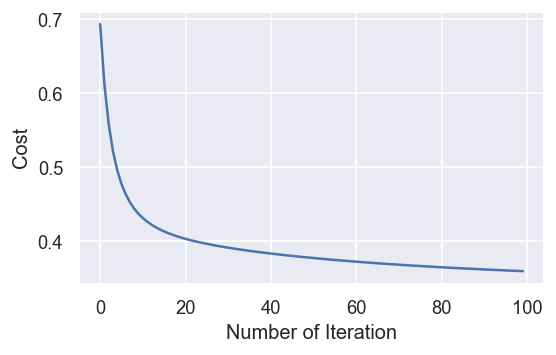

Logistic Regression (Manual) Test Accuracy: 86.89%


<IPython.core.display.Javascript object>

In [30]:
logistic_regression(x_train, y_train, x_test, y_test, 1, 100)

## <font color="blue">Manual Test Accuracy is <font color="red">**86.89%**</font></font><br>


### Sklearn Logistic Regression

In [31]:
accuracies = {}

lr = LogisticRegression()
lr.fit(x_train.T, y_train.T)
acc = lr.score(x_test.T, y_test.T) * 100

accuracies["Logistic Regression"] = acc
print("Logistic Regression (using Sklearn) Test Accuracy {:.2f}%".format(acc))

Logistic Regression (using Sklearn) Test Accuracy 86.89%


<IPython.core.display.Javascript object>

## K-Nearest Neighbour (KNN) Classification
<br>
Let's see what will be score if we use KNN algorithm.

Our model works with <font color="red">**86.89%**</font> accuracy.</font>

**KNN Algorithm**
<br>
<img src="http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1531424125/KNN_final_a1mrv9.png"/>

In [32]:
# KNN Model
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)  # n_neighbors means k
knn.fit(x_train.T, y_train.T)
prediction = knn.predict(x_test.T)

print("{} NN Score: {:.2f}%".format(2, knn.score(x_test.T, y_test.T) * 100))

2 NN Score: 77.05%


<IPython.core.display.Javascript object>

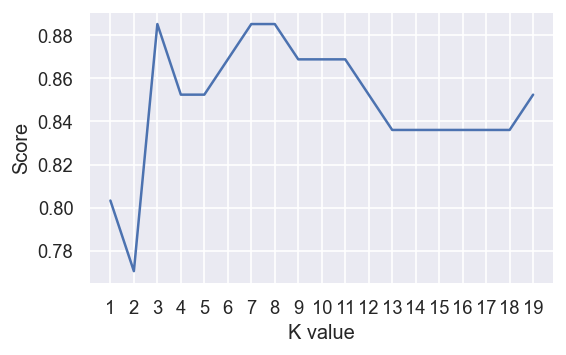

Maximum KNN Score is 88.52%


<IPython.core.display.Javascript object>

In [33]:
# try ro find best k value
scoreList = []
for i in range(1, 20):
    knn2 = KNeighborsClassifier(n_neighbors=i)  # n_neighbors means k
    knn2.fit(x_train.T, y_train.T)
    scoreList.append(knn2.score(x_test.T, y_test.T))

plt.figure(dpi=120)
plt.plot(range(1, 20), scoreList)
plt.xticks(np.arange(1, 20, 1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()

acc = max(scoreList) * 100
accuracies["KNN"] = acc
print("Maximum KNN Score is {:.2f}%".format(acc))

As you can see above if we define k as 3-7-8 we will reach maximum score. <br>
## <font color="green">KNN Model's Accuracy is <font color="red">88.52%</font></font>

## Support Vector Machine (SVM) Algorithm 

**Support Vector Machine Algorithm**
<br>
<img src="https://cdn-images-1.medium.com/max/1600/1*TudH6YvvH7-h5ZyF2dJV2w.jpeg" width="500px"/><br>
<img src="https://aitrends.com/wp-content/uploads/2018/01/1-19SVM-2.jpg" width="500px"/>


In [34]:
from sklearn.svm import SVC

<IPython.core.display.Javascript object>

In [35]:
svm = SVC(random_state=1)
svm.fit(x_train.T, y_train.T)

acc = svm.score(x_test.T, y_test.T) * 100
accuracies["SVM"] = acc
print("Test Accuracy of SVM Algorithm: {:.2f}%".format(acc))

Test Accuracy of SVM Algorithm: 88.52%


<IPython.core.display.Javascript object>

## <font color="orange">Test Accuracy of SVM Algorithm is <font color="red"> 88.52%</font></font>

## Naive Bayes Algorithm

**Naive Bayes Algorithm**
<br>
<img src="https://s3.ap-south-1.amazonaws.com/techleer/204.png" width="500px"/>

In [36]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(x_train.T, y_train.T)

acc = nb.score(x_test.T, y_test.T) * 100
accuracies["Naive Bayes"] = acc
print("Accuracy of Naïve Bayes: {:.2f}%".format(acc))

Accuracy of Naïve Bayes: 86.89%


<IPython.core.display.Javascript object>

## <font color="magenta">Accuracy of Naive Bayes: <font color="red">86.89%</font></font>

## Decision Tree Algorithm

**Decision Tree Algorithm**
<br>
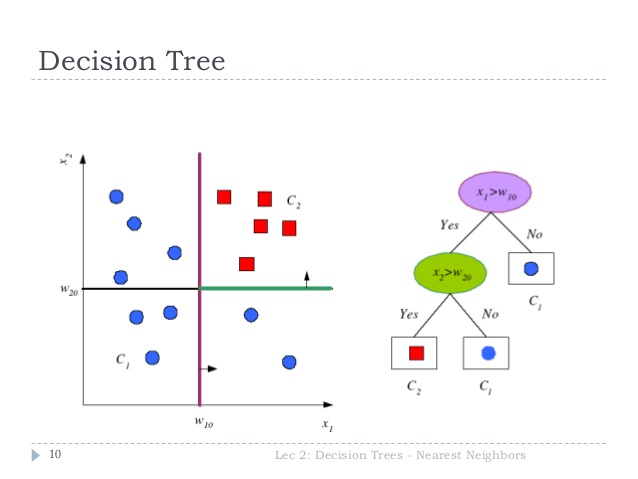

In [37]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(x_train.T, y_train.T)

acc = dtc.score(x_test.T, y_test.T) * 100
accuracies["Decision Tree"] = acc
print("Decision Tree Test Accuracy {:.2f}%".format(acc))

Decision Tree Test Accuracy 78.69%


<IPython.core.display.Javascript object>

## <font color="#CFC60E">Test Accuracy of Decision Tree Algorithm: <font color="red">78.69%</font></font>

## Random Forest Classification

In [38]:
# Random Forest Classification
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, random_state=1)
rf.fit(x_train.T, y_train.T)

acc = rf.score(x_test.T, y_test.T) * 100
accuracies["Random Forest"] = acc
print("Random Forest Algorithm Accuracy Score : {:.2f}%".format(acc))

Random Forest Algorithm Accuracy Score : 88.52%


<IPython.core.display.Javascript object>

## <font color="#0FBBAE">Test Accuracy of Random Forest: <font color="red">88.52%</font></font>

## Comparing Models

<Figure size 600x360 with 0 Axes>

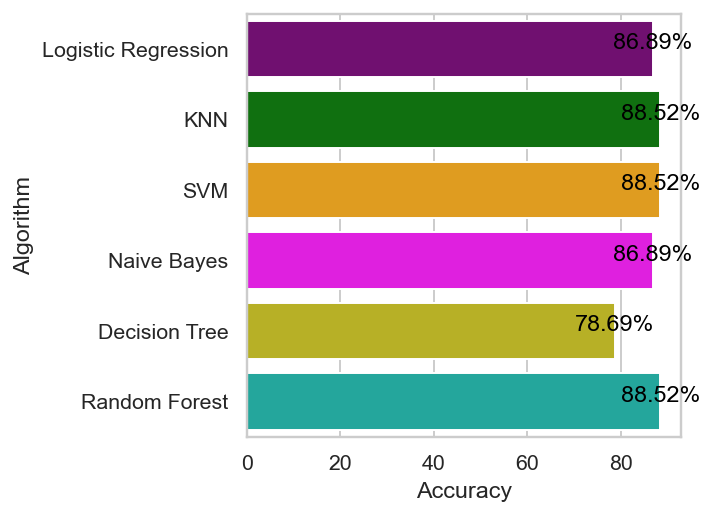

<IPython.core.display.Javascript object>

In [39]:
colors = ["purple", "green", "orange", "magenta", "#CFC60E", "#0FBBAE"]

sns.set_style("whitegrid")
plt.figure(dpi=120)
plt.figure(figsize=(4, 4))
plt.yticks(np.arange(0, 100, 10))
plt.ylabel("Algorithm")
plt.xlabel("Accuracy")
g = sns.barplot(
    y=list(accuracies.keys()), x=list(accuracies.values()), palette=colors, orient="h"
)
i = 0
for algorithm, accuracy in accuracies.items():
    g.text(accuracy, i, "{0:.2f}%".format(accuracy), color="black", ha="center")
    i += 1
plt.show()

## Confusion Matrix

In [40]:
# Predicted values
y_hat_lr = lr.predict(x_test.T)
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(x_train.T, y_train.T)
y_hat_knn = knn3.predict(x_test.T)
y_hat_svm = svm.predict(x_test.T)
y_hat_nb = nb.predict(x_test.T)
y_hat_dtc = dtc.predict(x_test.T)
y_hat_rf = rf.predict(x_test.T)

<IPython.core.display.Javascript object>

In [41]:
from sklearn.metrics import confusion_matrix

cm_lr = confusion_matrix(y_test, y_hat_lr)
cm_knn = confusion_matrix(y_test, y_hat_knn)
cm_svm = confusion_matrix(y_test, y_hat_svm)
cm_nb = confusion_matrix(y_test, y_hat_nb)
cm_dtc = confusion_matrix(y_test, y_hat_dtc)
cm_rf = confusion_matrix(y_test, y_hat_rf)

<IPython.core.display.Javascript object>

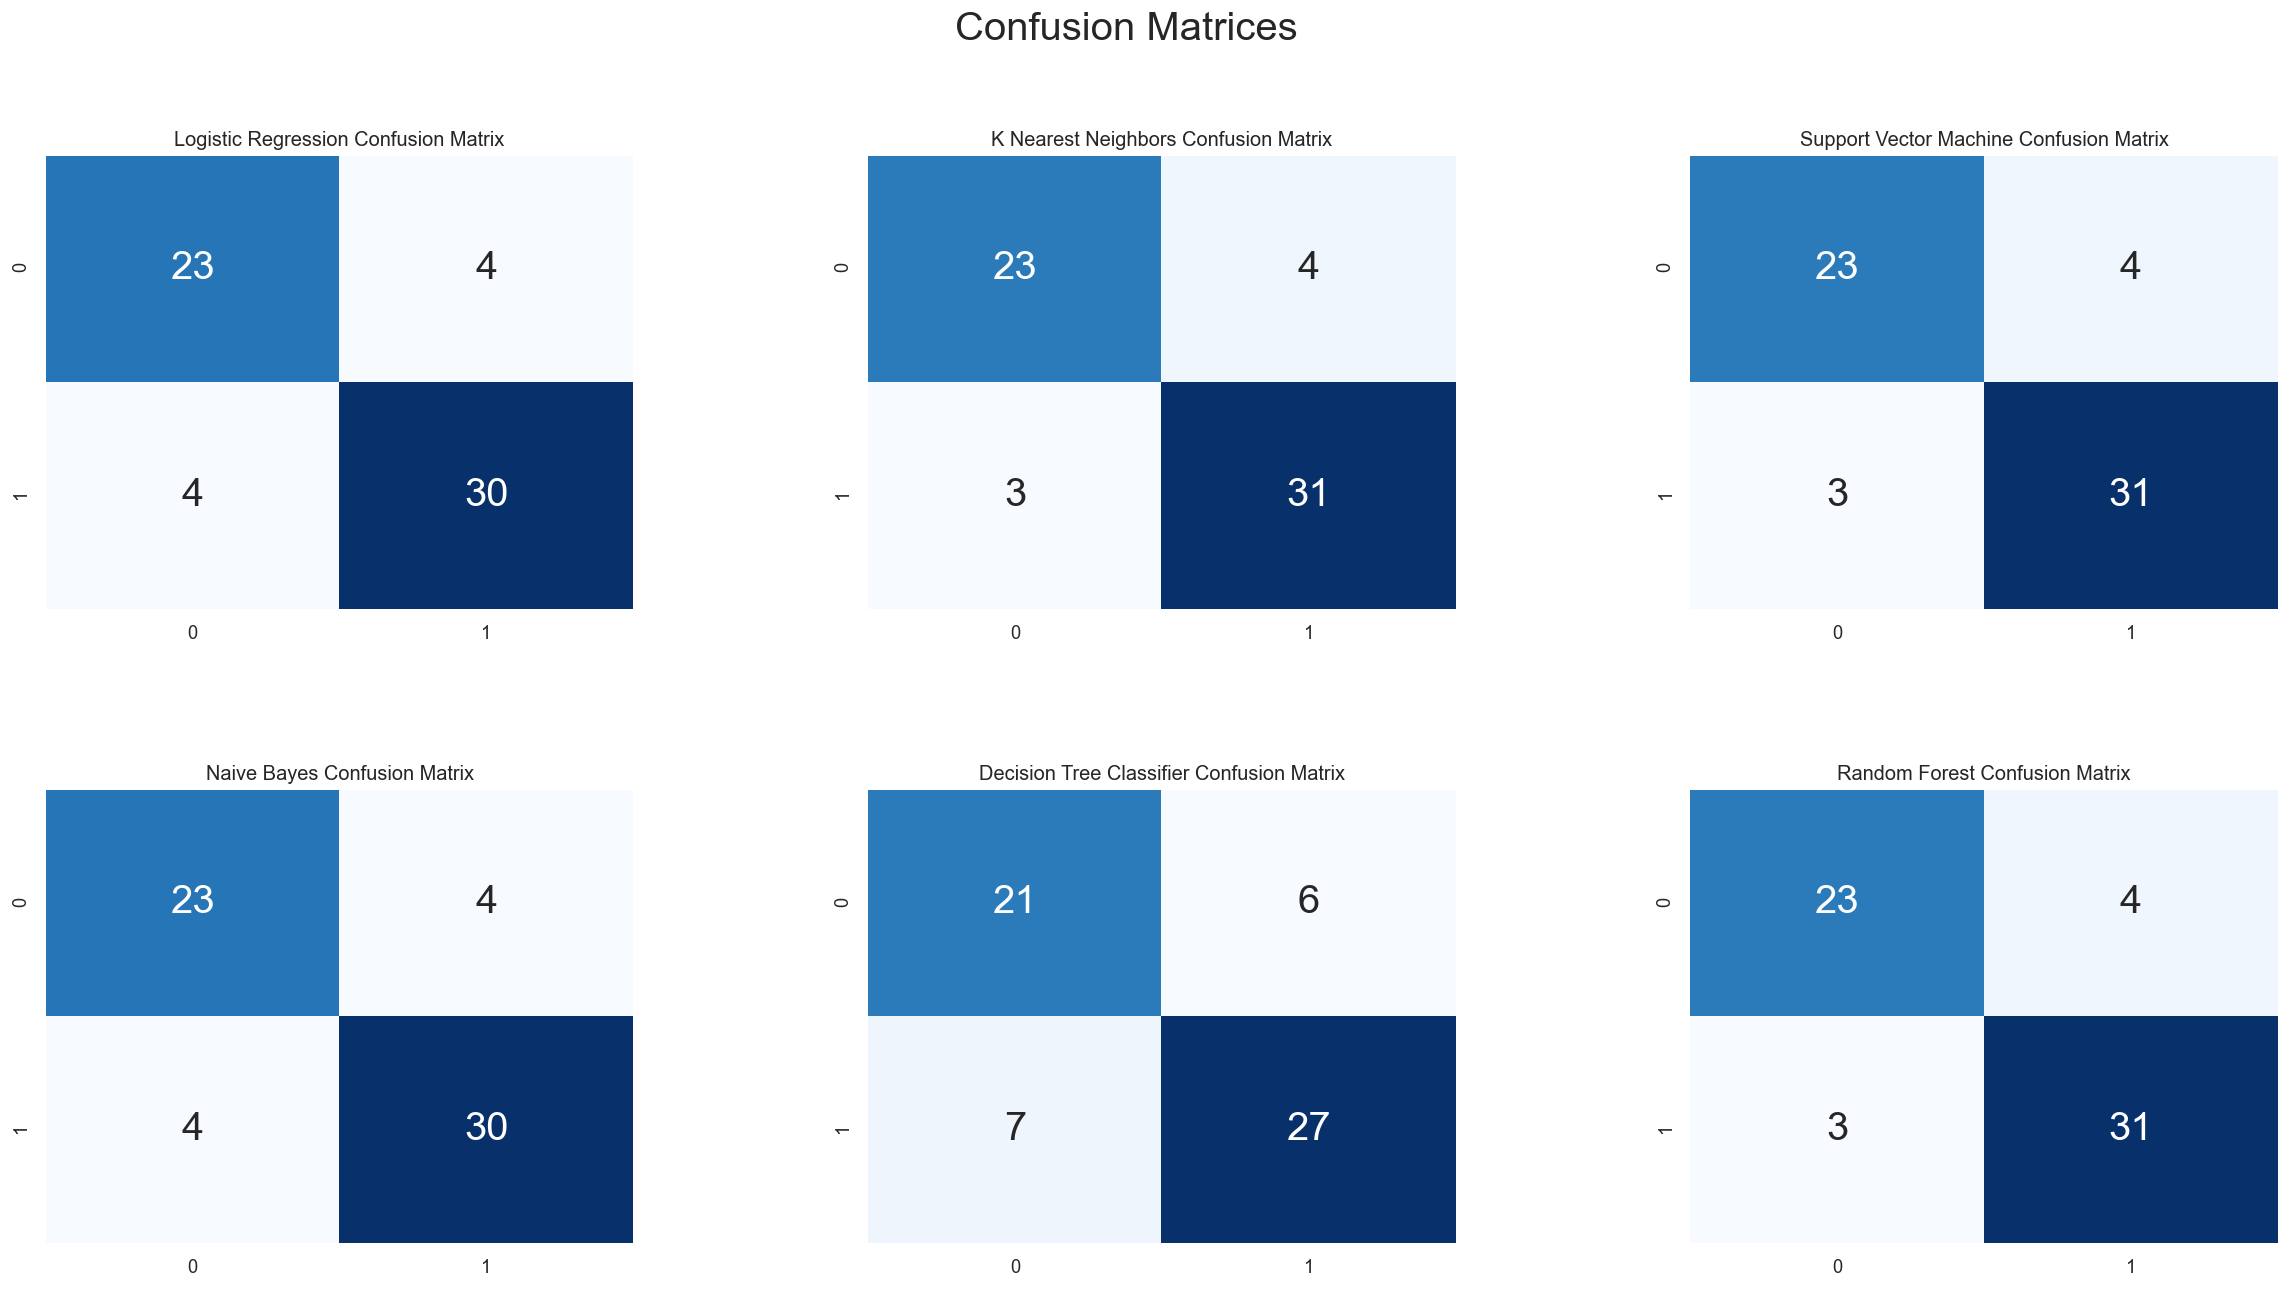

<IPython.core.display.Javascript object>

In [42]:
plt.figure(figsize=(24, 12), dpi=120)

plt.suptitle("Confusion Matrices", fontsize=24)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.subplot(2, 3, 1)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(
    cm_lr, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24}
)

plt.subplot(2, 3, 2)
plt.title("K Nearest Neighbors Confusion Matrix")
sns.heatmap(
    cm_knn, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24}
)

plt.subplot(2, 3, 3)
plt.title("Support Vector Machine Confusion Matrix")
sns.heatmap(
    cm_svm, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24}
)

plt.subplot(2, 3, 4)
plt.title("Naive Bayes Confusion Matrix")
sns.heatmap(
    cm_nb, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24}
)

plt.subplot(2, 3, 5)
plt.title("Decision Tree Classifier Confusion Matrix")
sns.heatmap(
    cm_dtc, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24}
)

plt.subplot(2, 3, 6)
plt.title("Random Forest Confusion Matrix")
sns.heatmap(
    cm_rf, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 24}
)

plt.show()